In [1]:
from os.path import isfile
from os import listdir
from os.path import join as joinpath

import numpy as np

from scipy.linalg import lstsq
from scipy.signal import savgol_filter

import pandas as pd
import matplotlib.pyplot as plt
import math

from src.wellClass import Well
from tqdm import tqdm

from sklearn.preprocessing import  StandardScaler
from sklearn import linear_model
from sklearn.svm import SVC

In [2]:
folder = "Full_las"

filePaths = ([joinpath(folder, file) for file in listdir(folder) if (isfile(joinpath(folder, file))
             and file.lower().endswith('las'))])

wells = [Well(filepath) for filepath in tqdm(filePaths[:])]

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [01:16<00:00,  1.37it/s]


In [3]:
data = pd.read_excel('Akan_Tab.xlsx')

In [4]:
data.head()

,Скважина,Статус,КС,ПС,ДС,ИК,БК,ГК,НК,КС.1,...,GKue,NGKue,Tau,Rk_Speed,Alpha,Top_C2vrT,Top_C2vrK,Top_C2bsh,Bot_C2bsh,Скважина.2
0,1892,готово,есть,есть,есть,есть,есть,есть,есть,200,...,1006.0,9600.0,3.0,400.0,0.15,1141.8,1160.9,1187.9,1236.8,1892
1,1899,готово,есть,есть,есть,есть,есть,есть,есть,200,...,955.0,8600.0,3.0,400.0,0.15,1048.8,1069.2,1096.2,1147.0,1899
2,1900,готово,есть,есть,есть,есть,есть,есть,есть,200,...,1950.0,15000.0,3.0,400.0,0.15,1023.0,1041.4,1066.6,1115.7,1900
3,1901,готово,есть,есть,есть,есть,есть,есть,есть,200,...,1904.0,15500.0,3.0,400.0,0.15,1144.0,1163.6,1192.0,1234.5,1901
4,1902,готово,есть,есть,есть,есть,есть,есть,есть,200,...,1001.0,9000.0,3.0,400.0,0.15,1165.6,1187.5,1220.6,1265.7,1902


In [5]:
filter_hor = ["Скважина","Top_C2vrT","Top_C2vrK","Top_C2bsh","Bot_C2bsh"]
strat = data[filter_hor]

In [6]:
strat.Скважина = strat.Скважина.astype(str)

C:\Programs\anaconda\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [7]:
for well in wells[:]:
    Df = strat[strat['Скважина'] == well.name]
    Df = Df.drop([filter_hor[0]] ,axis = 1)
    well.tops = []
    for name in Df.columns:
        well.tops.append(Df[name].values)

In [8]:
def norm(crv):
    return (crv - np.nanmin(crv)) / (np.nanmax(crv) - np.nanmin(crv))

def segmentation(dept, crv, delta):
    def find_mins(crv, d):
        mins = []
        for i in range (1, len(crv)-1):
            if ((crv[i-1] - crv[i]) >= 0 and (crv[i+1] - crv[i]) > 0) or ((crv[i-1] - crv[i]) > 0 and (crv[i+1] - crv[i]) >= 0):
                mins.append(d[i])
        return mins
    def find_maxs(crv, d):
        maxs = []
        for i in range (1, len(crv)-1):
            if ((crv[i-1] - crv[i]) <= 0 and (crv[i+1] - crv[i]) < 0) or ((crv[i-1] - crv[i]) < 0 and (crv[i+1] - crv[i]) <= 0):
                maxs.append(d[i])
        return maxs
    
    mins = find_mins(crv, dept)
    maxs = find_maxs(crv, dept)
    
    extrems = np.hstack((mins, maxs))
    extrems.sort()
    
    boundaries = []
    
    for i in range(len(extrems)-1):
        try:
            if abs(crv[dept == dept[dept >= extrems[i]][0]] - crv[dept == dept[dept <= extrems[i+1]][-1]]) < delta:
                continue
                
            crvAvg = (crv[dept == extrems[i]] + crv[dept == extrems[i+1]]) / 2
            
            ind = np.logical_and(dept >= extrems[i], dept <= extrems[i+1])
            dx = dept[ind]
          
            v1 = dx[crv[ind] <= crvAvg][0]
            v2 = dx[crv[ind] <= crvAvg][-1]
            
            if abs(crv[dept == v1] - crvAvg) < abs(crv[dept == v2] - crvAvg):   
                boundaries.append(v1)
            else:
                boundaries.append(v2)
        except:
            pass
    
    boundaries.sort()
    
    return np.array(boundaries)

43.0 142.70000000000005 51.03587500000002


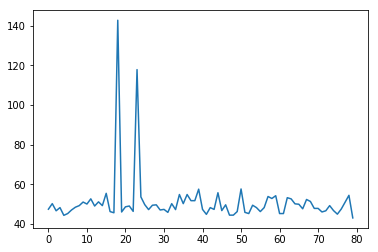

In [9]:
m1 = np.array([well.tops[0] for well in wells])
m2 = np.array([well.tops[-2] for well in wells])
mx = np.nanmin(m2-m1)
mn = np.nanmax(m2-m1)
s = np.nanmean(m2-m1)
plt.plot(m2-m1)
print(mx,mn,s)

In [10]:
print(len(wells))
wells = [well for well in wells if well.tops[-2]-well.tops[0] <= s + mx/2]
print(len(wells))

80
78


43.0 57.600000000000136 49.004743589743605


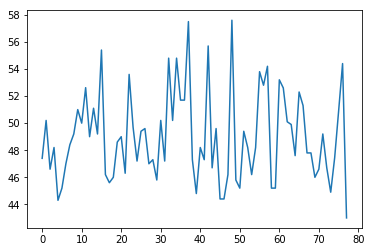

In [11]:
m1 = np.array([well.tops[0] for well in wells])
m2 = np.array([well.tops[-2] for well in wells])
mn = np.nanmin(m2-m1)
mx = np.nanmax(m2-m1)
s = np.nanmean(m2-m1)
plt.plot(m2-m1)
print(mn,mx,s)

#### Делим на тест и трейн

In [12]:
print(len(wells))
wells_train = wells[:60]
wells_test = wells[60:]

78


In [13]:
print(len(wells_train) , len(wells_test))

60 18


In [14]:
for well in wells:
    print(well.name)
    print(well.curves.keys())
    print('\n')

1899
dict_keys(['DEPT', 'DS', 'GK', 'NGK', 'PS', 'PZ', 'КХРНКНЦХЪ', 'МЮЯШЫЕМХЕ', 'KGL', 'KN', 'KN_GASH', 'KP', 'KP_GASH', 'ЙНККЕЙРНП', 'BK', 'IK', 'U1', 'U2', 'U3', 'REZ'])


1905
dict_keys(['DEPT', 'DS', 'GK', 'NGK', 'PS', 'PZ', 'КХРНКНЦХЪ', 'МЮЯШЫЕМХЕ', 'KGL', 'KN', 'KN_GASH', 'KP', 'KP_GASH', 'ЙНККЕЙРНП', 'BK', 'IK', 'U1', 'U2', 'U3', 'GGKP', 'DT', 'REZ'])


1918
dict_keys(['DEPT', 'DS', 'GK', 'NGK', 'PS', 'PZ', 'КХРНКНЦХЪ', 'МЮЯШЫЕМХЕ', 'KGL', 'KN', 'KN_GASH', 'KP', 'KP_GASH', 'ЙНККЕЙРНП', 'BK', 'IK', 'U1', 'U2', 'U3', 'REZ'])


1933
dict_keys(['DEPT', 'DS', 'GK', 'NGK', 'PS', 'PZ', 'КХРНКНЦХЪ', 'МЮЯШЫЕМХЕ', 'KGL', 'KN', 'KN_GASH', 'KP', 'KP_GASH', 'ЙНККЕЙРНП', 'BK', 'IK', 'U1', 'U2', 'U3', 'REZ', 'MGZ', 'MPZ'])


1956
dict_keys(['DEPT', 'DS', 'GK', 'NGK', 'PS', 'PZ', 'КХРНКНЦХЪ', 'МЮЯШЫЕМХЕ', 'KGL', 'KN', 'KN_GASH', 'KP', 'KP_GASH', 'ЙНККЕЙРНП', 'BK', 'IK', 'U1', 'U2', 'U3', 'GGKP', 'REZ'])


1957
dict_keys(['DEPT', 'DS', 'GK', 'NGK', 'PS', 'PZ', 'КХРНКНЦХЪ', 'МЮЯШЫЕМХЕ', 'KGL', '

In [15]:
def get_layers(d, crv, hmin, hmax, sm_window, sm_deg, delta, top = None, bot = None):
    
    layers = []
    
    sm_crv = savgol_filter(crv, sm_window, sm_deg ,mode = 'nearest')
    segs = segmentation(d, sm_crv, delta)
    
    if top is not None:
        layers = [[top, jseg] for jseg in segs[np.logical_and(segs-top >= hmin, segs-top <= hmax)]]
    
    elif bot is not None:
        layers = [[iseg, bot] for iseg in segs[np.logical_and(bot-segs >= hmin, bot-segs <= hmax)]]
    
    else:
        for iseg in segs:
            jsegs = segs[np.logical_and(segs-iseg >= hmin, segs-iseg <= hmax)]
            
            for jseg in jsegs:
                layers.append([iseg, jseg])
    
    return np.array(layers)

In [16]:
for well in tqdm(wells_train):
    try:
        ind = np.isfinite(well.curves["GK"])
        well.layers = get_layers(well.curves["DEPT"][ind], norm(well.curves["GK"])[ind], mn, mx, 33, 3, 0.05, None, None)
        #print(well.layers)
        well.layers_labels = np.zeros(len(well.layers))
    except:
        pass

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 29.25it/s]


In [17]:
for well in tqdm(wells_test):
    try:
        ind = np.isfinite(well.curves["GK"])
        well.layers = get_layers(well.curves["DEPT"][ind], norm(well.curves["GK"])[ind], mn, mx, 33, 3, 0.05, None, None)
        #print(well.layers)
        well.layers_labels = np.zeros(len(well.layers))
    except:
        pass

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 59.87it/s]


In [18]:
max = 0

for well in wells:
    ind = np.logical_and(well.curves['DEPT'] >= well.tops[2],well.curves['DEPT'] <= well.curves['DEPT'][-1])
    cutDept = well.curves['DEPT'][ind]
    startDept = cutDept[0]
    gk = norm(well.curves['GK'])[ind]
    found = False
    for i in range(0,len(gk)):
        if gk[i] < 0.03:
            well.maxDept = cutDept[i]
            well.deptCutLen = cutDept[i]-startDept
            break
for well in wells:
    ind = np.logical_and(well.curves['DEPT'] >= well.tops[2],well.curves['DEPT'] <= well.maxDept)
    print(well.name)
    print(well.tops[2][0],well.maxDept,np.round(well.deptCutLen,1),np.nanmin(norm(well.curves['GK'][ind])))
    print('\n')
print(np.nanmean(np.array([well.deptCutLen for well in wells])))

1899
1096.2 1098.2 2.0 0.0


1905
1215.4 1217.1 1.7 0.0


1918
1130.4 1131.9 1.5 0.0


1933
1144.2 1147.1 2.9 0.0


1956
1142.5 1145.5 3.0 0.0


1957
1123.2 1126.7 3.5 0.0


1963
1193.6 1196.7 3.1 0.0


1968
1156.8 1158.7 1.9 0.0


1982
1162.2 1164.4 2.2 0.0


1985
1155.2 1160.9 5.7 0.0


1990
1244.2 1246.3 2.1 0.0


2010
1186.4 1189.3 2.9 0.0


2018
1138.2 1140.8 2.6 0.0


2023
1269.8 1272.7 2.9 0.0


2024
1241.0 1243.2 2.2 0.0


2026
1346.2 1348.6 2.4 0.0


2028
1161.8 1164.8 3.0 0.0


2032
1132.4 1138.4 6.0 0.0


2100
1146.0 1149.6 3.6 0.0


2101
1233.7 1236.6 2.9 0.0


2102
1316.6 1320.7 4.1 0.0


2103
1157.7 1159.4 1.7 0.0


2105
1316.0 1318.3 2.3 0.0


2106
1262.6 1267.1 4.5 0.0


2107
1219.2 1221.8 2.6 0.0


2108
1298.0 1304.8 6.8 0.0


2109
1281.0 1284.4 3.4 0.0


2110
1196.2 1200.0 3.8 0.0


2111
1160.7 1165.2 4.5 0.0


2112
1149.8 1152.9 3.1 0.0


2115
1249.7 1251.3 1.6 0.0


2116
1157.2 1158.0 0.8 0.0


2117
1287.0 1288.7 1.7 0.0


2118
1261.2 1262.7 1.5 0.0


2119
1281.4 12

1899
[1048.8] [1096.2]


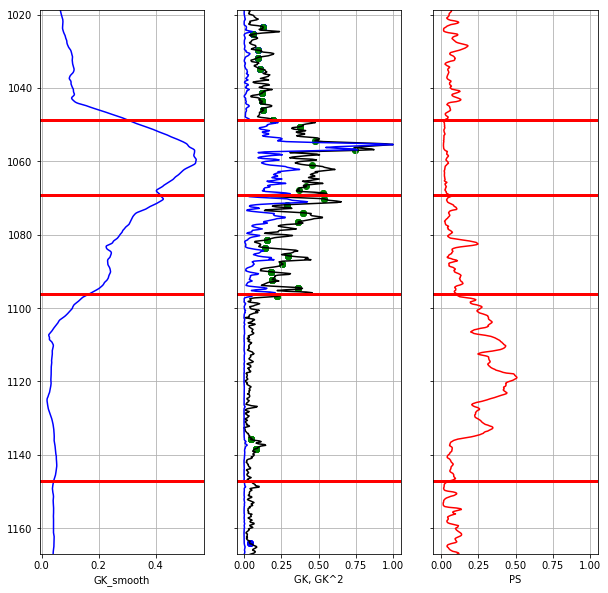

1905
[1165.2] [1215.4]


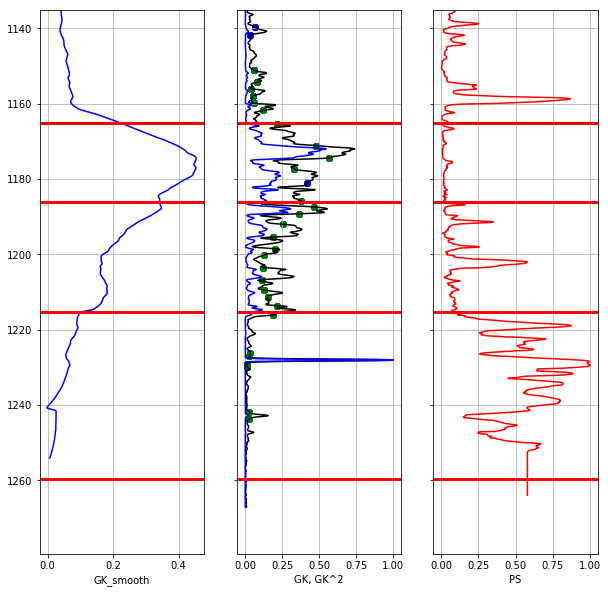

1918
[1083.8] [1130.4]


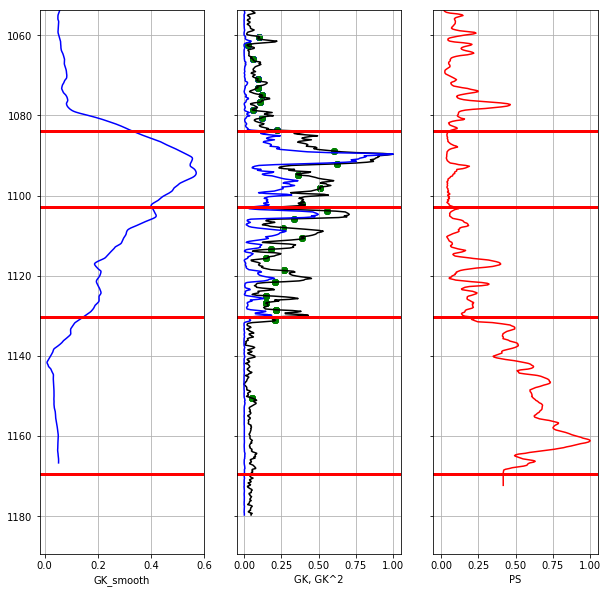

1933
[1096.] [1144.2]


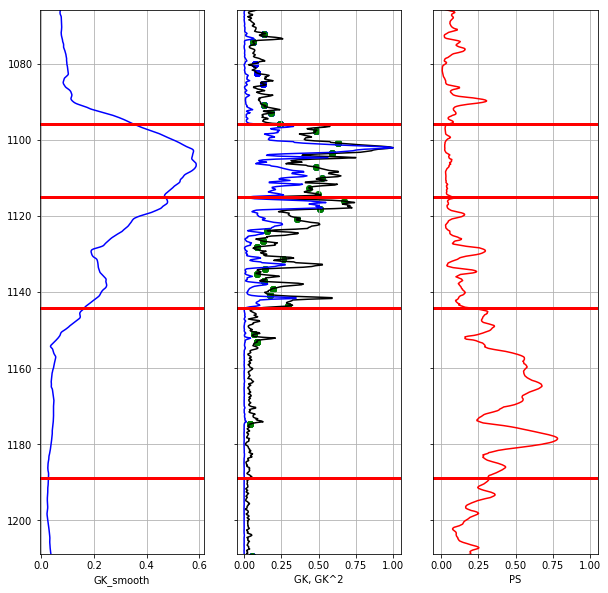

1956
[1098.2] [1142.5]


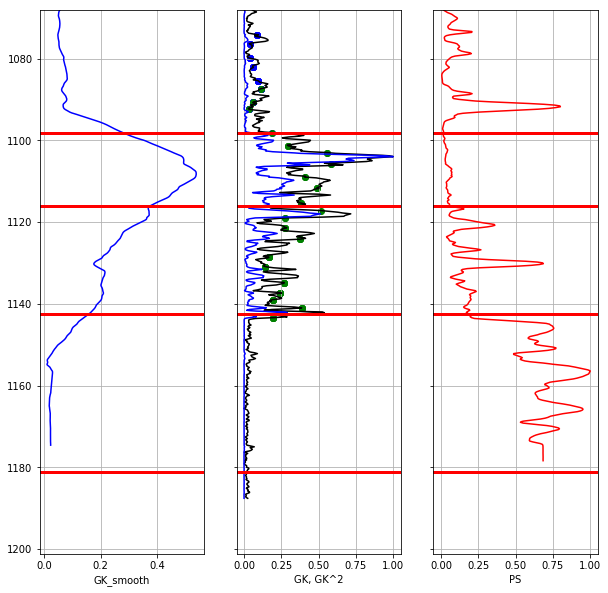

In [24]:
import matplotlib.pyplot as plt

for well in wells_train[:5]:
    try:
            print(well.name)
            fig, f = plt.subplots(nrows = 1, ncols =3, sharey = True, figsize = (10,10))
            ccrv = savgol_filter(norm(well.curves["GK"]), 261, 3 ,mode = 'nearest')
            ccrv2 = savgol_filter(norm(well.curves["GK"])*norm(well.curves["GK"]),171,5,mode='nearest')
            
            #f[0].plot(norm(well.curves["NGK"]),  well.curves["DEPT"], 'black')
            #f[0].plot(norm(well.curves["NGK"]),  well.curves["DEPT"], 'black')
            f[0].plot(ccrv,  well.curves["DEPT"], 'blue')
            #f[0].plot(norm(well.curves["NGK"])*norm(well.curves["NGK"]),  well.curves["DEPT"], 'green')
            ngk2smth = savgol_filter(norm(well.curves["NGK"])*norm(well.curves["NGK"]),261,3,mode='nearest')
            #f[0].plot(ngk2smth,  well.curves["DEPT"], 'pink')
            
            #f[1].plot(norm(well.curves["PS"]),  well.curves["DEPT"], 'r')
            f[1].plot(norm(well.curves["GK"]),  well.curves["DEPT"], 'black')
            f[1].plot(norm(well.curves["GK"])*norm(well.curves["GK"]),  well.curves["DEPT"], 'blue')
            #f[1].plot(savgol_filter(norm(well.curves["GK"]),261,3,mode='nearest'),  well.curves["DEPT"], 'r')
            f[2].plot(norm(well.curves["PZ"]),  well.curves["DEPT"], 'r')
            #f[2].plot(ccrv2,  well.curves["DEPT"], 'green')
            
            print(well.tops[0], well.tops[-2])
            #print(well.layers)
            layer = [well.layers[i][0] for i in range(len(well.layers))]
            for i in range(len(well.layers)):
                layer.append(well.layers[i][1])
            gkValues0 = []
            for i in range(len(well.layers)):
                gkValues0.append(norm(well.curves['GK'])[well.curves['DEPT'] == well.layers[i][0]][0])
            gkValues1 = []
            for i in range(len(well.layers)):
                gkValues1.append(norm(well.curves['GK'])[well.curves['DEPT'] == well.layers[i][1]][0])
            l0 = [well.layers[i][0] for i in range(len(well.layers))]
            l1 = [well.layers[i][1] for i in range(len(well.layers))]
            for i in range(len(f)):
                for j in range(len(well.tops)):
                    f[i].axhline(y = well.tops[j], linewidth = 3, color = 'red')
            #f[1].axhline(y = well.maxDept,linewidth = 2, color = 'blue')
            #for i in range(len(f)):
            #    f[i].scatter( , well.curves["DEPT"] , color = 'b')
            for i in range(len(f)):
                f[i].set_ylim([well.tops[0]-30, well.tops[-1]+20])
            f[1].scatter(gkValues0,l0,color = 'b')
            f[1].scatter(gkValues1,l1,color = 'g')

            f[0].set_xlabel("GK_smooth")

            f[1].set_xlabel("GK, GK^2")

            f[2].set_xlabel("PS")
            
            f[0].grid()
            f[1].grid()
            f[2].grid()

            f[0].invert_yaxis()
            plt.show()
    except Exception as e:
        print('error')
        print(e)

In [25]:
for well in wells_train:
        #print(well.name)
        top = well.layers[:,0]
        dif = np.abs(top-well.tops[0])
        top_value = top[dif == np.nanmin(dif)][0]

        bot = well.layers[:,1]
        dif = np.abs(bot-well.tops[-2])
        bot_value = bot[dif == np.nanmin(dif)][0]
        #well.layers_labels[np.logical_and(top_value == well.layers[:,0],
        #                                  bot_value == well.layers[:,1])] = 1
        well.layers_labels[top_value == well.layers[:,0]] = 1
        well.layers_labels[top_value == well.layers[:,1]] = 2
    

In [26]:
def get_features(well):
    dept   = well.curves["DEPT"]
    ps = well.curves["GK"]
    #посмотреть данные
    #print(ps)
    layers = well.layers
    
    ps = norm(ps)
    ps2 = ps*ps
    pss = savgol_filter(ps, 261, 3 ,mode = 'nearest')
    pss2 = savgol_filter(ps2, 171, 5 ,mode = 'nearest')
    grd = np.gradient(pss)
    
    ngk = well.curves["NGK"]
    ngk2 = ngk*ngk
    ngksmth = savgol_filter(ngk,171,5,mode='nearest')
    
    pz = well.curves["PZ"]
    pz_smth = savgol_filter(pz,171,3,mode='nearest')
    pz2 = pz*pz
    n = len(layers)
    f1 = np.nan*np.ones(n)
    f2 = np.nan*np.ones(n)
    f3 = np.nan*np.ones(n)
    
    f4 = np.nan*np.ones(n)
    f5 = np.nan*np.ones(n)
    
    f6 = np.nan*np.ones(n)
    
    f7 = np.nan*np.ones(n)
    f8 = np.nan*np.ones(n)
    
    f9 = np.nan*np.ones(n)
    f10 = np.nan*np.ones(n)
    f11 = np.nan*np.ones(n)
    f12 = np.nan*np.ones(n)
    f13 = np.nan*np.ones(n)
    f14 = np.nan*np.ones(n)
    f15 = np.nan*np.ones(n)
    f16 = np.nan*np.ones(n)
    f17 = np.nan*np.ones(n)
    f18 = np.nan*np.ones(n)
    f19 = np.nan*np.ones(n)
    f20 = np.nan*np.ones(n)
    f21 = np.nan*np.ones(n)
    
    for i in range(n):
        
        p3 = (layers[i][1]-layers[i][0])/3
        ind1 = np.logical_and(dept >= layers[i][0]     , dept <= layers[i][0] +   p3)
        ind2 = np.logical_and(dept >= layers[i][0] - 4, dept <= layers[i][0])
        
        
        all = np.logical_and(dept >= layers[i][0], dept <= layers[i][1])
        all_past10_before10 = np.logical_and(dept >= layers[i][0]-10, dept <= layers[i][1]+10)
        p2_past10 = np.logical_and(dept >= layers[i][1], dept <= layers[i][1]+10)
        p2_before10 = np.logical_and(dept >= layers[i][1]-10, dept <= layers[i][1])
        p2_before20 = np.logical_and(dept >= layers[i][1]-20, dept <= layers[i][1])
        p2_past5 = np.logical_and(dept >= layers[i][1], dept <= layers[i][1]+5)
        p2_past2 = np.logical_and(dept >= layers[i][1], dept <= layers[i][1]+2)
        p2_before5 = np.logical_and(dept >= layers[i][1]-5, dept <= layers[i][1])
        p2_before2 = np.logical_and(dept >= layers[i][1]-2, dept <= layers[i][1])
        p2_before3_past3 = np.logical_and(dept >= layers[i][1]-3, dept <= layers[i][1]+3)
        f1[i] = np.nanmax(ps[ind1])+np.nanmean(ps[ind1])
        f2[i] = np.nanmean(ps[ind2])
        f3[i] = np.nanmax(ps2[ind1])+np.nanmean(ps2[ind1])
        f4[i] = np.nanmean(ps2[ind2])
        
        
        f6[i] = np.nanmin(ps[p2_past10])
        f8[i] = np.nanmin(ps[p2_past2])
        f9[i] = np.nanmax(ps[p2_before2])
        f7[i] = (np.nanmin(pss[p2_before3_past3])+np.nanmax(pss[p2_before3_past3]))/2
        f5[i] = np.nanstd(pss[p2_before10])
        f18[i] = np.nanstd(ps[p2_past10])
        f19[i] = np.nanstd(pz[p2_past10])
        
        
    features = np.vstack((f1,
                          f2,
                          f3,
                          f4, #f1,f2,f3,f4 - кровля - 95%
                          f5,
                          f6,
                          f7,
                          f8,
                          f9,
                          #f10,
                          #f11,
                          #f12,
                          #f13,
                          #f14,
                          #f15,
                          #f16,
                          #f17,
                          f18,
                          f19,
                          #f20
                         ))
    
    return features


def get_TrainingSet(wells):
    
    features = None
    labels = None
    
    for well in wells:
        
        if  features is not None:
            features = np.hstack((features, get_features(well)))
            labels = np.hstack((labels, well.layers_labels))
        else:
            features = get_features(well)
            labels = well.layers_labels
    
    features = features.T 
    
    ind = np.ones(len(labels), dtype=bool)
    for i in range(len(features)):
        if any(np.isnan(features[i])):
            ind[i] = False

    return (features[ind],  labels[ind])  

In [27]:
features_train, labels_train = get_TrainingSet(wells_train)

C:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: All-NaN slice encountered
C:\Programs\anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [28]:
print(len(features_train),len(labels_train))

7284 7284


In [29]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
sv = SVC(probability=True, C=2, class_weight='balanced', cache_size=2000,
             verbose=True, kernel='rbf',gamma = 'auto', degree=7, shrinking=True)

In [30]:
sv.fit(features_train, labels_train)

[LibSVM]

SVC(C=2, cache_size=2000, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=7, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [31]:
features_test, labels_test = get_TrainingSet(wells_test)

C:\Programs\anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: All-NaN slice encountered


In [32]:
learn = sv.predict(features_train)
test = sv.predict(features_test)

In [33]:
print(accuracy_score(labels_train, learn))
print(accuracy_score(labels_test, test))

0.7752608456891817
0.6295641931684335


In [34]:
for well in tqdm(wells_test[:]):
    try:
        features = get_features(well).T
        
        ind = np.ones(len(features), dtype=bool)
        for i in range(len(features)):
            if any(np.isnan(features[i])):
                ind[i] = False
        
        scores = sv.predict_proba(features[ind])
        ind = scores[:,1].argmax()
        #print(ind)
        well.stratigraphy = well.layers[ind]
        #print(well.stratigraphy)
    except:
        
        pass

 11%|█████████▏                                                                         | 2/18 [00:00<00:04,  3.71it/s]C:\Programs\anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
 39%|████████████████████████████████▎                                                  | 7/18 [00:01<00:02,  5.32it/s]C:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: All-NaN slice encountered
C:\Programs\anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
 50%|█████████████████████████████████████████▌                                         | 9/18 [00:01<00:01,  5.44it/s]C:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: All-NaN slice encountered
C:\Programs\anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [37]:
allCount = len(wells_test)
goodCount = 0
topCount = 0
botCount = 0
for well in wells_test:
    well.good = True
    #print(well.name)
    goodTop = False
    goodBot = False
    if (abs(well.tops[0][0]-well.stratigraphy[0]) < 3):
        topCount += 1
        goodTop = True
    if (abs(well.tops[2][0]-well.stratigraphy[1]) < 3):
        botCount += 1
        goodBot = True
    if (goodBot and goodTop):
        goodCount += 1
        #print('good')
    else:
        print(well.name)
        print('Top:',goodTop)
        print('Bot:',goodBot)
        well.good = False
        print('\n')
print('Tops:',str(topCount/allCount))
print('Bots',str(botCount/allCount))
print('Accurancy:',str(goodCount/allCount))
svcScore = np.round(goodCount/allCount,2)

2340
Top: True
Bot: False


2345
Top: False
Bot: False


2396
Top: True
Bot: False


2402
Top: True
Bot: False


Tops: 0.9444444444444444
Bots 0.7777777777777778
Accurancy: 0.7777777777777778


2340


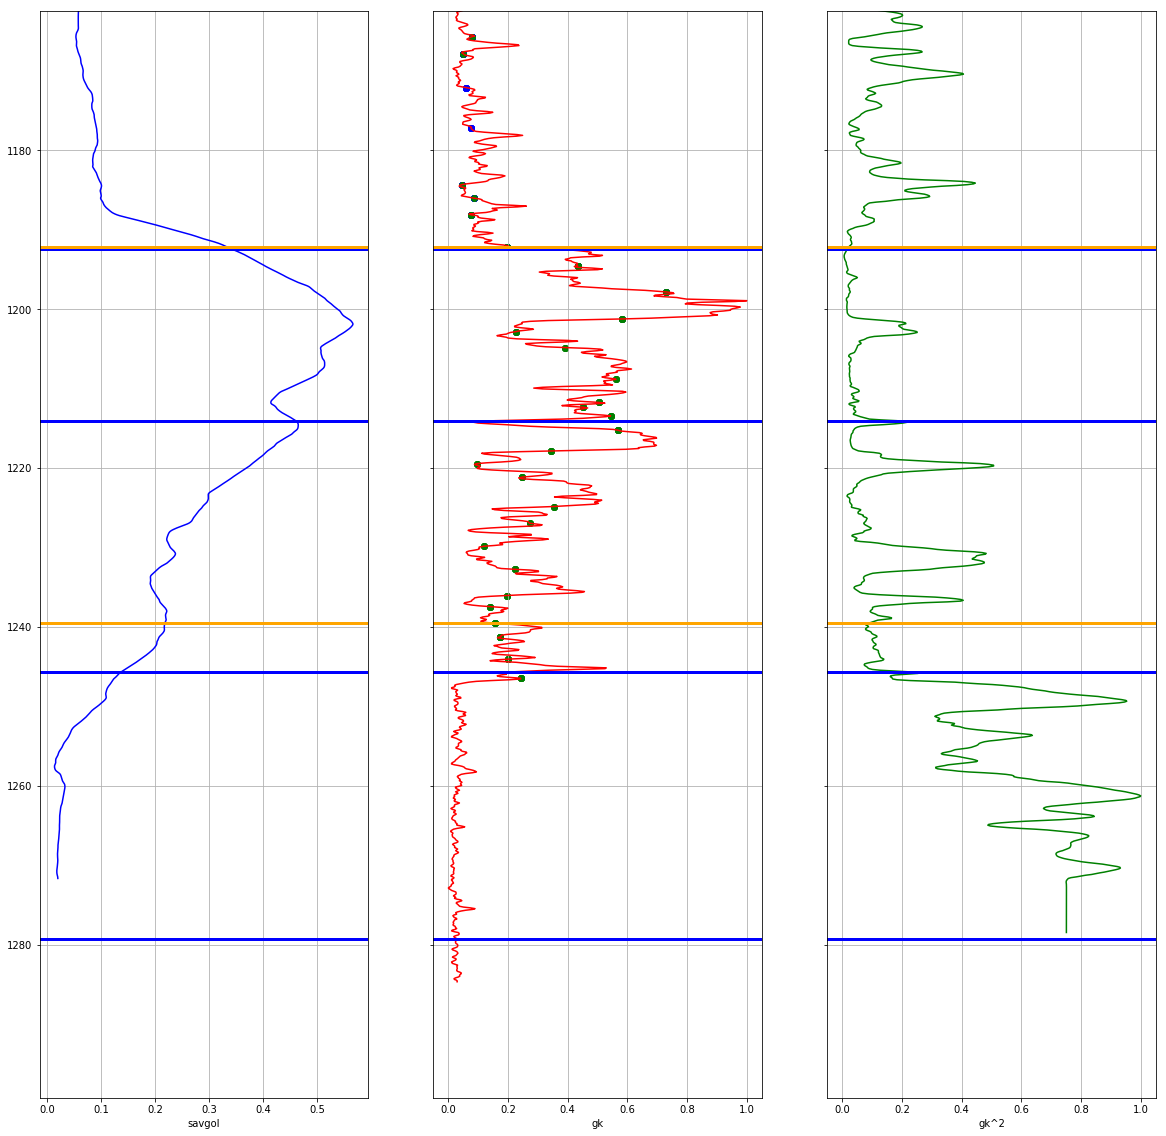

2345


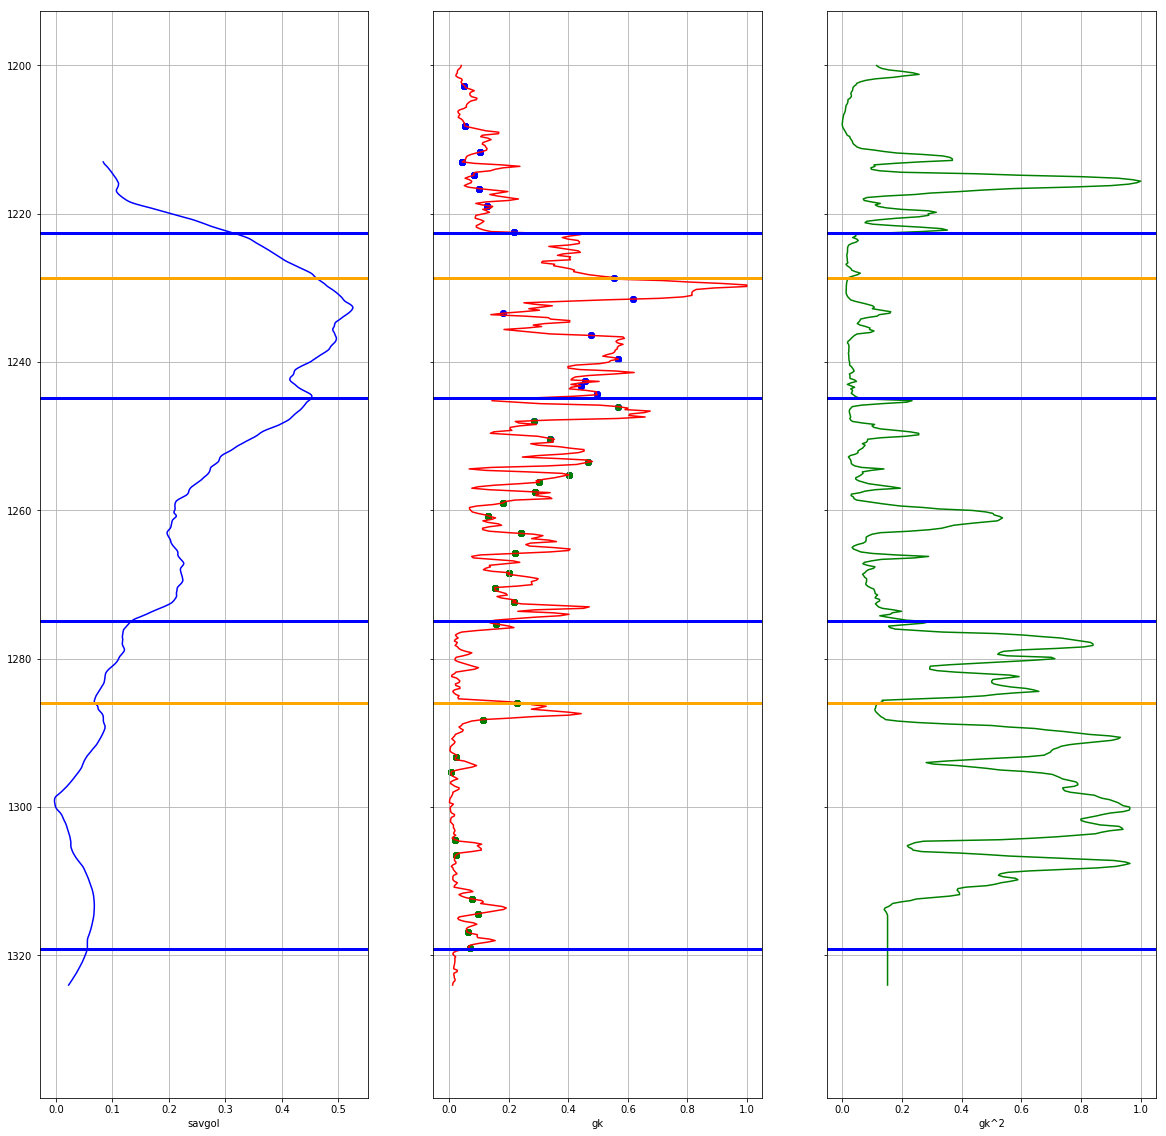

2396


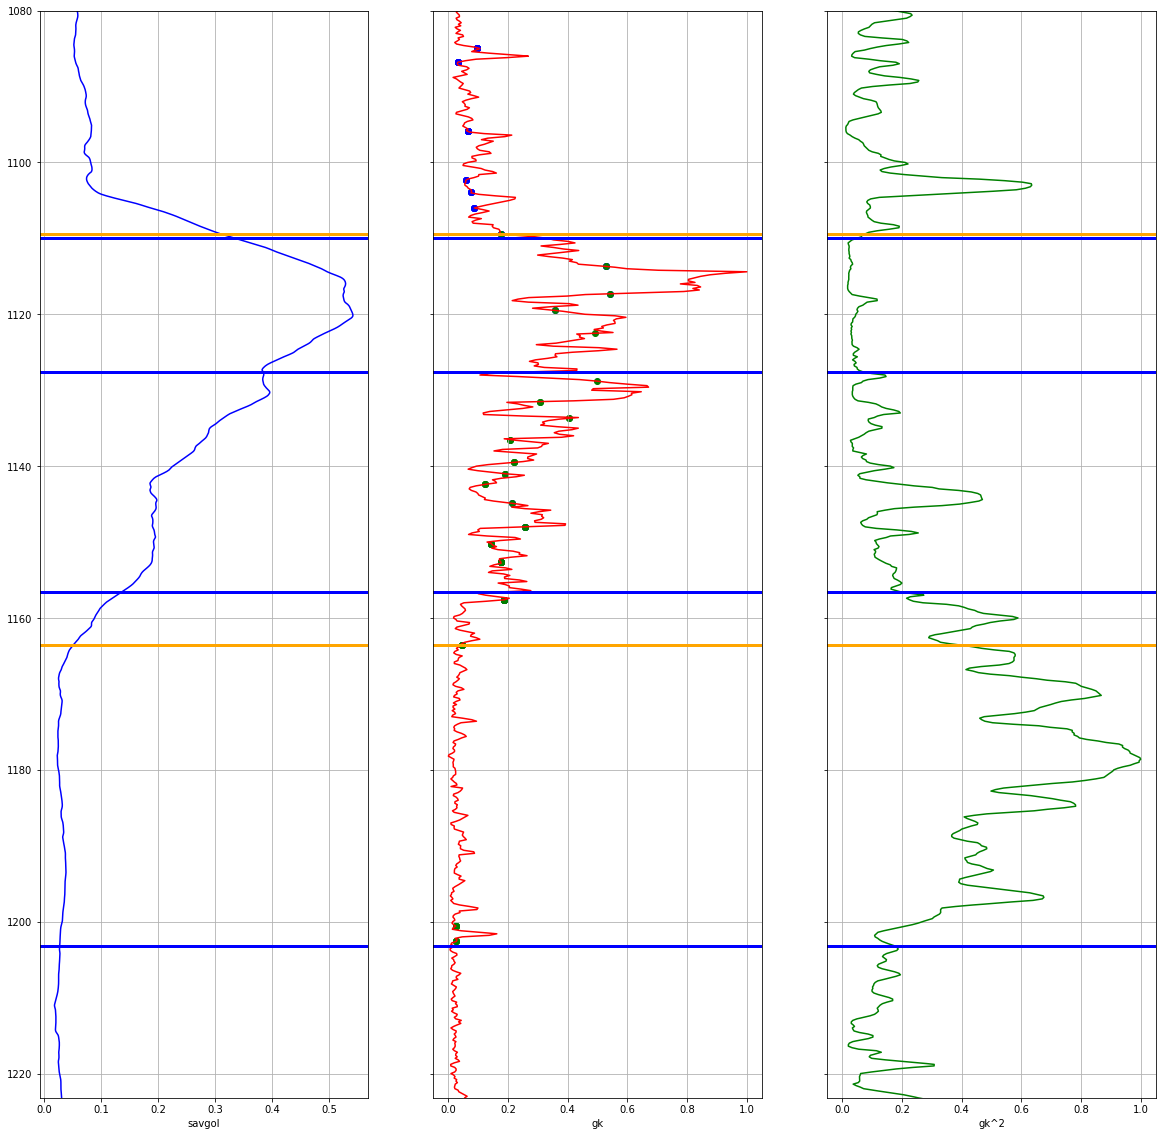

2402


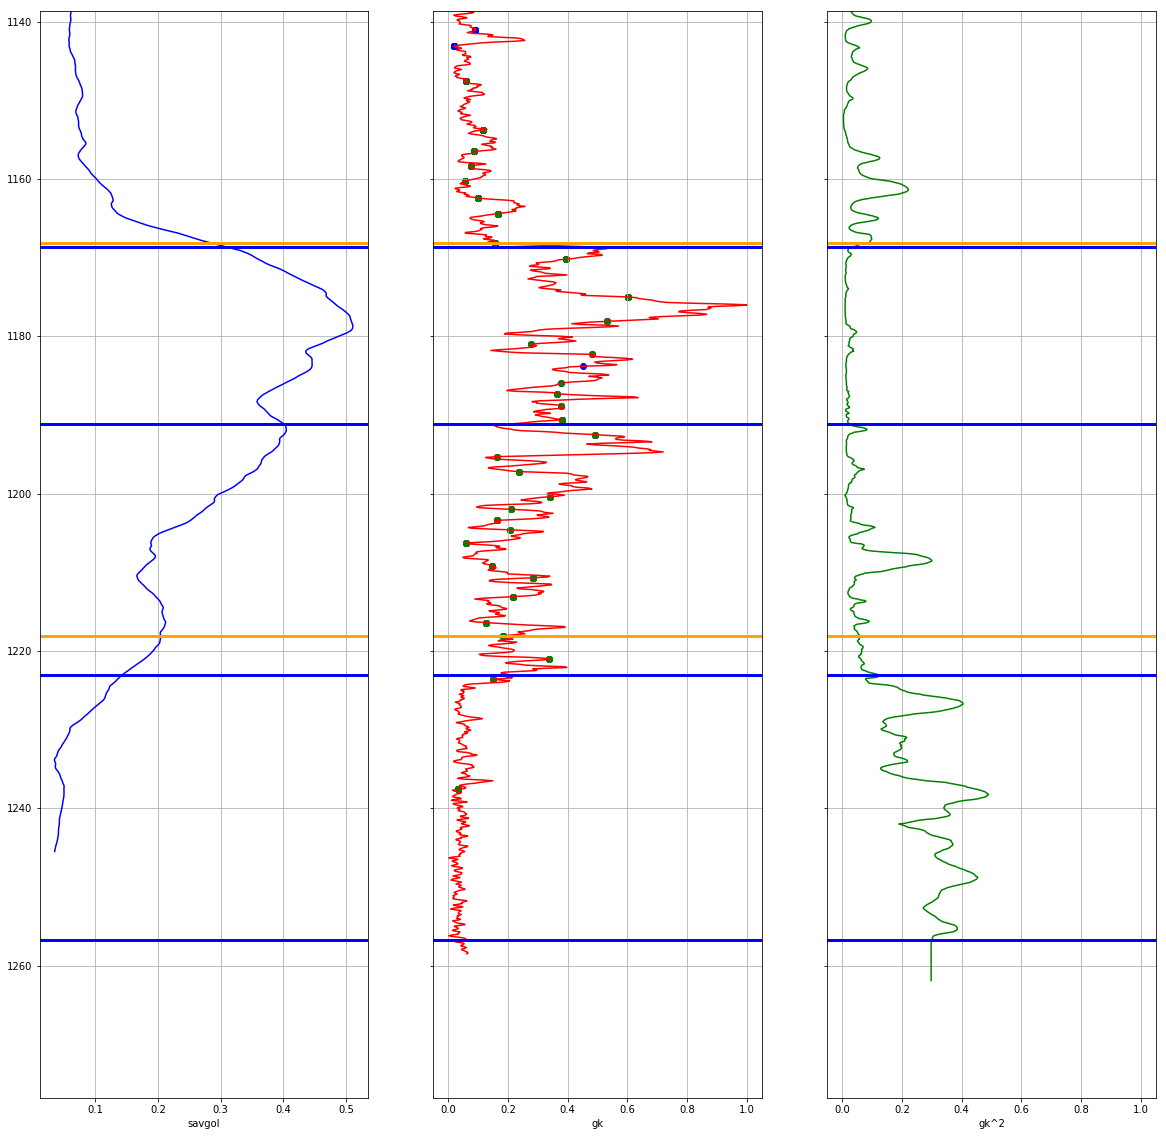

In [31]:
import matplotlib.pyplot as plt

for well in wells_test[:]:
    try:
            if well.good == True: continue
            print(well.name)

            fig, f = plt.subplots(nrows = 1, ncols =3, sharey = True, figsize = (20,20))

            f[0].plot(savgol_filter(norm(well.curves["GK"]),261,3,mode='nearest'),  well.curves["DEPT"], 'blue')
            #f[0].plot(norm(well.curves["NGK"]),  well.curves["DEPT"], 'black')
            #f[0].plot(norm(well.curves["NGK"])*norm(well.curves["NGK"]),  well.curves["DEPT"], 'green')
            ngk2smth = savgol_filter(norm(well.curves["NGK"])*norm(well.curves["NGK"]),171,5,mode='nearest')
            ngksmth = savgol_filter(norm(well.curves["NGK"]),171,5,mode='nearest')
            #f[0].plot(ngksmth,  well.curves["DEPT"], 'blue')
            #f[0].plot(ngk2smth,  well.curves["DEPT"], 'pink')
            f[1].plot(norm(well.curves["GK"]),  well.curves["DEPT"], 'r')
            f[2].plot(norm(well.curves["PZ"]),  well.curves["DEPT"], 'green')
            #print(well.tops[2] - well.tops[0])
            #print(well.layers)
            layer = [well.layers[i][0] for i in range(len(well.layers))]
            for i in range(len(well.layers)):
                layer.append(well.layers[i][1])
            gkValues0 = []
            for i in range(len(well.layers)):
                gkValues0.append(norm(well.curves['GK'])[well.curves['DEPT'] == well.layers[i][0]][0])
            gkValues1 = []
            for i in range(len(well.layers)):
                gkValues1.append(norm(well.curves['GK'])[well.curves['DEPT'] == well.layers[i][1]][0])
            l0 = [well.layers[i][0] for i in range(len(well.layers))]
            l1 = [well.layers[i][1] for i in range(len(well.layers))]
            for i in range(len(f)):
                for j in range(len(well.tops)):
                    f[i].axhline(y = well.tops[j], linewidth = 3, color = 'blue')
                    
            for i in range(len(f)):
                for j in range(len(well.stratigraphy)):
                    f[i].axhline(y = well.stratigraphy[j], linewidth = 3, color = 'orange')        
                    
            #for i in range(len(f)):
            #    f[i].scatter( , well.curves["DEPT"] , color = 'b')
            for i in range(len(f)):
                f[i].set_ylim([well.tops[0]-30, well.tops[-1]+20])
            f[1].scatter(gkValues0,l0,color = 'b')
            f[1].scatter(gkValues1,l1,color = 'g')

            f[0].set_xlabel("savgol")

            f[1].set_xlabel("gk")

            f[2].set_xlabel("gk^2")
            
            f[0].grid()
            f[1].grid()
            f[2].grid()

            f[0].invert_yaxis()
            plt.show()
    except Exception as e:
        print('error')
        print(well.name)

######Try Ada boost

In [38]:
from sklearn.ensemble import AdaBoostClassifier


In [39]:
adaModel = AdaBoostClassifier(
    base_estimator=None,
    n_estimators=50,
    learning_rate=1.0,
    algorithm='SAMME.R',
    random_state=None)

In [40]:
adaModel.fit(features_train, labels_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [41]:
testingAcc = adaModel.predict(features_test)

In [42]:
print(accuracy_score(labels_test,testingAcc))

0.8545347467608951


In [43]:
for well in tqdm(wells_test[:]):
    try:
        features = get_features(well).T
        
        ind = np.ones(len(features), dtype=bool)
        for i in range(len(features)):
            if any(np.isnan(features[i])):
                ind[i] = False
        
        scores = adaModel.predict_proba(features[ind])
        ind = scores[:,1].argmax()
        #print(ind)
        well.stratigraphy = well.layers[ind]
        #print(well.stratigraphy)
    except Exception as e:
        print(e)
        pass

 11%|█████████▏                                                                         | 2/18 [00:00<00:03,  4.05it/s]C:\Programs\anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
 39%|████████████████████████████████▎                                                  | 7/18 [00:01<00:02,  5.48it/s]C:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: All-NaN slice encountered
C:\Programs\anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
 50%|█████████████████████████████████████████▌                                         | 9/18 [00:01<00:01,  5.56it/s]C:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: All-NaN slice encountered
C:\Programs\anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [44]:
allCount = len(wells_test)
goodCount = 0
topCount = 0
botCount = 0
for well in wells_test:
    well.good = True
    #print(well.name)
    goodTop = False
    goodBot = False
    if (abs(well.tops[0][0]-well.stratigraphy[0]) < 3):
        topCount += 1
        goodTop = True
    if (abs(well.tops[2][0]-well.stratigraphy[1]) < 3):
        botCount += 1
        goodBot = True
    if (goodBot and goodTop):
        goodCount += 1
        #print('good')
    else:
        print(well.name)
        print('Top:',goodTop)
        print('Bot:',goodBot)
        well.good = False
        print('\n')
print('Tops:',str(topCount/allCount))
print('Bots',str(botCount/allCount))
print('Accurancy:',str(goodCount/allCount))
adaScore = np.round(goodCount/allCount,2)
print(adaScore)

2342
Top: True
Bot: False


2346
Top: True
Bot: False


2396
Top: True
Bot: False


2401
Top: False
Bot: True


2402
Top: False
Bot: False


2403
Top: True
Bot: False


Tops: 0.8888888888888888
Bots 0.7222222222222222
Accurancy: 0.6666666666666666
0.67


In [45]:
from sklearn.linear_model import LogisticRegression

In [46]:
logisticModel = LogisticRegression()

In [47]:
logisticModel.fit(features_train, labels_train)
testingAcc = adaModel.predict(features_test)
print(accuracy_score(labels_test,testingAcc))

C:\Programs\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Programs\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8545347467608951


In [48]:
for well in tqdm(wells_test[:]):
    try:
        features = get_features(well).T
        
        ind = np.ones(len(features), dtype=bool)
        for i in range(len(features)):
            if any(np.isnan(features[i])):
                ind[i] = False
        
        scores = logisticModel.predict_proba(features[ind])
        ind = scores[:,1].argmax()
        #print(ind)
        well.stratigraphy = well.layers[ind]
        #print(well.stratigraphy)
    except Exception as e:
        print(e)
        pass

 11%|█████████▏                                                                         | 2/18 [00:00<00:03,  4.09it/s]C:\Programs\anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
 39%|████████████████████████████████▎                                                  | 7/18 [00:01<00:01,  6.05it/s]C:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: All-NaN slice encountered
C:\Programs\anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
 50%|█████████████████████████████████████████▌                                         | 9/18 [00:01<00:01,  6.17it/s]C:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: All-NaN slice encountered
C:\Programs\anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [49]:
allCount = len(wells_test)
goodCount = 0
topCount = 0
botCount = 0
for well in wells_test:
    well.good = True
    #print(well.name)
    goodTop = False
    goodBot = False
    if (abs(well.tops[0][0]-well.stratigraphy[0]) < 3):
        topCount += 1
        goodTop = True
    if (abs(well.tops[2][0]-well.stratigraphy[1]) < 3):
        botCount += 1
        goodBot = True
    if (goodBot and goodTop):
        goodCount += 1
        #print('good')
    else:
        print(well.name)
        print('Top:',goodTop)
        print('Bot:',goodBot)
        well.good = False
        print('\n')
print('Tops:',str(topCount/allCount))
print('Bots',str(botCount/allCount))
print('Accurancy:',str(goodCount/allCount))
linearScore = np.round(goodCount/allCount,2)
print(linearScore)

2340
Top: True
Bot: False


2342
Top: True
Bot: False


2346
Top: True
Bot: False


2394
Top: True
Bot: False


2396
Top: True
Bot: False


2397
Top: True
Bot: False


2402
Top: True
Bot: False


2403
Top: True
Bot: False


Tops: 1.0
Bots 0.5555555555555556
Accurancy: 0.5555555555555556
0.56


In [50]:
from sklearn.ensemble import GradientBoostingClassifier
gradModel = GradientBoostingClassifier(loss='deviance',learning_rate=0.1,
    n_estimators=200,max_depth=3,max_features=11,criterion='mse')
gradModel.fit(features_train, labels_train)
testingAcc = gradModel.predict(features_test)
print(accuracy_score(labels_test,testingAcc))

0.9287396937573617


In [51]:
for well in tqdm(wells_test[:]):
    try:
        features = get_features(well).T
        
        ind = np.ones(len(features), dtype=bool)
        for i in range(len(features)):
            if any(np.isnan(features[i])):
                ind[i] = False
        
        scores = gradModel.predict_proba(features[ind])
        ind = scores[:,1].argmax()
        #print(ind)
        well.stratigraphy = well.layers[ind]
        #print(well.stratigraphy)
    except Exception as e:
        print(e)
        pass

 11%|█████████▏                                                                         | 2/18 [00:00<00:04,  3.41it/s]C:\Programs\anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
 39%|████████████████████████████████▎                                                  | 7/18 [00:01<00:02,  5.23it/s]C:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: All-NaN slice encountered
C:\Programs\anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
 50%|█████████████████████████████████████████▌                                         | 9/18 [00:01<00:01,  5.22it/s]C:\Programs\anaconda\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: All-NaN slice encountered
C:\Programs\anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [52]:
allCount = len(wells_test)
goodCount = 0
topCount = 0
botCount = 0
for well in wells_test:
    well.good = True
    #print(well.name)
    goodTop = False
    goodBot = False
    if (abs(well.tops[0][0]-well.stratigraphy[0]) < 3):
        topCount += 1
        goodTop = True
    if (abs(well.tops[2][0]-well.stratigraphy[1]) < 3):
        botCount += 1
        goodBot = True
    if (goodBot and goodTop):
        goodCount += 1
        #print('good')
    else:
        print(well.name)
        print('Top:',goodTop)
        print('Bot:',goodBot)
        well.good = False
        print('\n')
print('Tops:',str(topCount/allCount))
print('Bots',str(botCount/allCount))
print('Accurancy:',str(goodCount/allCount))
gradientScore = np.round(goodCount/allCount,2)
print(gradientScore)

2340
Top: True
Bot: False


2394
Top: True
Bot: False


2396
Top: True
Bot: False


2401
Top: True
Bot: False


Tops: 1.0
Bots 0.7777777777777778
Accurancy: 0.7777777777777778
0.78


In [55]:
print('Scores : %')
print('SVC :',svcScore)
print('Ada :',adaScore)
print('Linear :',linearScore)
print('Gradient :',gradientScore)

Scores : %
SVC : 0.78
Ada : 0.67
Linear : 0.56
Gradient : 0.78


######Обучение

In [ ]:
for well in tqdm(wells_train[:]):
    try:
        features = get_features(well).T
        
        ind = np.ones(len(features), dtype=bool)
        for i in range(len(features)):
            if any(np.isnan(features[i])):
                ind[i] = False
        
        scores = sv.predict_proba(features[ind])
        ind = scores[:,1].argmax()
        #print(ind)
        well.stratigraphy = well.layers[ind]
        #print(well.stratigraphy)
    except:
        pass

In [ ]:
import matplotlib.pyplot as plt

for well in wells_train[:10]:
    try:
            if well.good: continue
            print(well.name)

            fig, f = plt.subplots(nrows = 1, ncols =3, sharey = True, figsize = (20,20))

            f[0].plot(norm(well.curves["NGK"]),  well.curves["DEPT"], 'black')
            f[1].plot(norm(well.curves["PS"]),  well.curves["DEPT"], 'r')
            f[2].plot(norm(well.curves["GK"]),  well.curves["DEPT"], 'r')
            f[2].plot(norm(well.curves["GK"])*norm(well.curves["GK"]),  well.curves["DEPT"], 'green')
            #print(well.tops[2] - well.tops[0])
            #print(well.layers)
            layer = [well.layers[i][0] for i in range(len(well.layers))]
            for i in range(len(well.layers)):
                layer.append(well.layers[i][1])
            gkValues0 = []
            for i in range(len(well.layers)):
                gkValues0.append(norm(well.curves['GK'])[well.curves['DEPT'] == well.layers[i][0]][0])
            gkValues1 = []
            for i in range(len(well.layers)):
                gkValues1.append(norm(well.curves['GK'])[well.curves['DEPT'] == well.layers[i][1]][0])
            l0 = [well.layers[i][0] for i in range(len(well.layers))]
            l1 = [well.layers[i][1] for i in range(len(well.layers))]
            for i in range(len(f)):
                for j in range(len(well.tops)):
                    f[i].axhline(y = well.tops[j], linewidth = 3, color = 'red')
                    
            for i in range(len(f)):
                for j in range(len(well.stratigraphy)):
                    f[i].axhline(y = well.stratigraphy[j], linewidth = 3, color = 'orange')        
                    
            #for i in range(len(f)):
            #    f[i].scatter( , well.curves["DEPT"] , color = 'b')
            for i in range(len(f)):
                f[i].set_ylim([well.tops[0]-30, well.tops[-1]+20])
            f[2].scatter(gkValues0,l0,color = 'b')
            f[2].scatter(gkValues1,l1,color = 'g')

            f[0].set_xlabel("NGK")

            f[1].set_xlabel("PS")

            f[2].set_xlabel("GK")
            
            f[0].grid()
            f[1].grid()
            f[2].grid()

            f[0].invert_yaxis()
            plt.show()
    except Exception as e:
        print('error')
        print(well.name)

In [ ]:
allCount = len(wells_train)
goodCount = 0
topCount = 0
botCount = 0
for well in wells_train:
    well.good = True
    print(well.name)
    goodTop = False
    goodBot = False
    if (abs(well.tops[0][0]-well.stratigraphy[0]) < 2.5):
        topCount += 1
        goodTop = True
    if (abs(well.tops[2][0]-well.stratigraphy[1]) < 3):
        botCount += 1
        goodBot = True
    if (goodBot and goodTop):
        goodCount += 1
        print('good')
    else:
        print('Top:',goodTop)
        print('Bot:',goodBot)
        well.good = False
    print('\n')
print('Tops:',str(topCount/allCount))
print('Bots',str(botCount/allCount))
print('Accurancy:',str(goodCount/allCount))